# GoogLeNet

### ConvBlock

In [4]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        super(ConvBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                              kernel_size=kernel_size, padding=padding, stride=stride)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)
        return x

In [126]:
# previous layer 192, 100, 100

tensor = torch.tensor([[1, 2, 3],[1, 2, 3]])
print(tensor.shape)
data = torch.randn((192, 100, 100))

conv1 = ConvBlock(in_channels=192, out_channels=64, kernel_size=1, padding=0)
output_1 = conv1(data)
print(f"output 1 = {output_1.shape}")

conv2 = ConvBlock(in_channels=192, out_channels=128, kernel_size=3, padding=1)
output_2 = conv2(data)
print(f"output 2 = {output_2.shape}")

conv3 = ConvBlock(in_channels=192, out_channels=32, kernel_size=5, padding=2)
output_3 = conv3(data)
print(f"output 3 = {output_3.shape}")

conv4 = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
output_4 = conv4(data)
print(f"output 4 = {output_4.shape}")

concat = torch.concat([
    output_1, output_2, output_3, output_4
], axis=0)

print(f"concat = {concat.shape}")

torch.Size([2, 3])
output 1 = torch.Size([64, 100, 100])
output 2 = torch.Size([128, 100, 100])
output 3 = torch.Size([32, 100, 100])
output 4 = torch.Size([192, 100, 100])
concat = torch.Size([416, 100, 100])


### Inception Naive

In [21]:
class NaiveInceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3, ch5x5):
        super(NaiveInceptionModule, self).__init__()
        self.branch1 = ConvBlock(in_channels=in_channels, out_channels=ch1x1, kernel_size=1)
        self.branch2 = ConvBlock(in_channels=in_channels, out_channels=ch3x3, kernel_size=3, padding=1)
        self.branch3 = ConvBlock(in_channels=in_channels, out_channels=ch5x5, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)

    def forward(self, x):
        output1 = self.branch1(x)
        output2 = self.branch2(x)
        output3 = self.branch3(x)
        output4 = self.pool(x)
        concatenated = torch.concat([output1, output2, output3, output4], axis=0)
        return concatenated

data = torch.randn((192, 100, 100))
module = NaiveInceptionModule(in_channels=192, ch1x1=64, ch3x3=128, ch5x5=32)
concatenated = module(data)
print(f"concatenated = {concatenated.shape}")


concatenated = torch.Size([416, 100, 100])


### Inception Module

In [125]:
import torch
import torch.nn as nn
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionModule, self).__init__()
        self.branch1 = ConvBlock(in_channels=in_channels, out_channels=ch1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels=in_channels, out_channels=ch3x3red, kernel_size=1),
            ConvBlock(in_channels=ch3x3red, out_channels=ch3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels=in_channels, out_channels=ch5x5red, kernel_size=1),
            ConvBlock(in_channels=ch5x5red, out_channels=ch5x5, kernel_size=5, padding=2)
        )
        self.pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            ConvBlock(in_channels=in_channels, out_channels=pool_proj, kernel_size=1)
        )

    def forward(self, x):
        output1 = self.branch1(x)
        output2 = self.branch2(x)
        output3 = self.branch3(x)
        output4 = self.pool(x)
        concatenated = torch.concat([output1, output2, output3, output4], axis=1)
        return concatenated

data = torch.randn((1, 192, 100, 100))
module = InceptionModule(in_channels=192, ch1x1=64, ch3x3red=96, ch3x3=128, ch5x5red=16, ch5x5=32, pool_proj=32)
concatenated = module(data)
print(f"concatenated = {concatenated.shape}")

concatenated = torch.Size([1, 256, 100, 100])


### GoogLeNet Model (224, 224)

In [123]:
import torch
import torch.nn as nn

class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=3, stride=2)
        self.conv1_pool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1)
        self.conv3_pool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.inception1 = InceptionModule(in_channels=192, ch1x1=64, ch3x3red=96, ch3x3=128, ch5x5red=16, ch5x5=32, pool_proj=32)
        self.inception2 = InceptionModule(in_channels=256, ch1x1=128, ch3x3red=128, ch3x3=192, ch5x5red=32, ch5x5=96, pool_proj=64)
        self.inception2_pool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.inception3 = InceptionModule(in_channels=480, ch1x1=192, ch3x3red=96, ch3x3=208, ch5x5red=16, ch5x5=48, pool_proj=64)
        self.inception4 = InceptionModule(in_channels=512, ch1x1=160, ch3x3red=112, ch3x3=224, ch5x5red=24, ch5x5=64, pool_proj=64)
        self.inception5 = InceptionModule(in_channels=512, ch1x1=128, ch3x3red=128, ch3x3=256, ch5x5red=24, ch5x5=64, pool_proj=64)
        self.inception6 = InceptionModule(in_channels=512, ch1x1=112, ch3x3red=144, ch3x3=288, ch5x5red=32, ch5x5=64, pool_proj=64)
        self.inception7 = InceptionModule(in_channels=528, ch1x1=256, ch3x3red=160, ch3x3=320, ch5x5red=32, ch5x5=128, pool_proj=128)
        self.inception7_pool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.inception8 = InceptionModule(in_channels=832, ch1x1=256, ch3x3red=160, ch3x3=320, ch5x5red=32, ch5x5=128, pool_proj=128)
        self.inception9 = InceptionModule(in_channels=832, ch1x1=384, ch3x3red=192, ch3x3=384, ch5x5red=48, ch5x5=128, pool_proj=128)
        self.inception9_pool = nn.AvgPool2d(kernel_size=7)
        self.fc = nn.Linear(in_features=1024, out_features=1000)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_pool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv3_pool(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception2_pool(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.inception7(x)
        x = self.inception7_pool(x)
        x = self.inception8(x)
        x = self.inception9(x)
        x = self.inception9_pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

data = torch.randn(2, 3, 224, 224)
model = GoogLeNet()
output = model(data)
print(f"output = {output.shape}")

output = torch.Size([2, 1000])


### GoogLeNet Custom by CIFAR10 (32, 32)

In [115]:
import torch
import torch.nn as nn

class GoogLeNetCIFAR(nn.Module):
    def __init__(self):
        super(GoogLeNetCIFAR, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=192, kernel_size=3, padding=1)
        self.conv1_pool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.inception1 = InceptionModule(in_channels=192, ch1x1=64, ch3x3red=96, ch3x3=128, ch5x5red=16, ch5x5=32, pool_proj=32)
        self.inception2 = InceptionModule(in_channels=256, ch1x1=128, ch3x3red=128, ch3x3=192, ch5x5red=32, ch5x5=96, pool_proj=64)
        self.inception2_pool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.fc = nn.Linear(in_features=480*8*8, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_pool(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception2_pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

data = torch.randn(2, 3, 32, 32)
model = GoogLeNetCIFAR()
output = model(data)
print(f"output = {output.shape}")

output = torch.Size([2, 10])


### CIFAR10 Learning

In [121]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
from torch.optim import SGD

seed = 42
torch.manual_seed(42)
BATCH_SIZE = 8
LR = 0.03
EPOCHS = 10
DEVICE = "cuda"

data = CIFAR10(root="data", train=True, download=True, transform=ToTensor())
len_data = len(data)
dataloader = DataLoader(dataset=data, batch_size=BATCH_SIZE)

model = GoogLeNetCIFAR()
model.to(DEVICE)
optimizer = SGD(model.parameters(), lr=LR)
loss_function = nn.CrossEntropyLoss()

epoch_losses, epoch_accs = [], []
for epoch in range(EPOCHS):
    epoch_loss, epoch_acc = 0., 0
    for X, Y in tqdm(dataloader, desc="진행중"):
        X, Y = X.to(DEVICE), Y.to(DEVICE)

        pred = model(X)

        loss = loss_function(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(X)
        pred_max_indices = torch.argmax(pred, axis=1)
        corrects = (pred_max_indices == Y).sum()
        epoch_acc += corrects.cpu()

    epoch_losses.append(epoch_loss / len_data)
    epoch_accs.append(epoch_acc / len_data)


Files already downloaded and verified


진행중: 100%|██████████| 6250/6250 [00:43<00:00, 145.26it/s]


### GoogLeNet Learning Visualization - CIFAR10

Text(0.5, 0, 'Epoch')

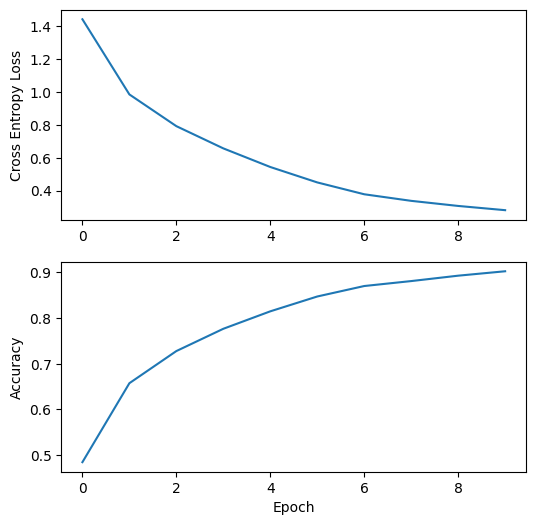

In [122]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
axes[0].plot(range(len(epoch_losses)), epoch_losses)
axes[0].set_ylabel("Cross Entropy Loss")
axes[1].plot(range(len(epoch_accs)), epoch_accs)
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")